In [2]:
import numpy as np
from itertools import product, combinations, combinations_with_replacement, permutations
from collections import defaultdict
from tqdm import tqdm

#### (Inductive logic programming in the context of prop ositional logic) Le p,q,r be propositional variables (6p)

Since i find it intreating to apply theory to parties i will try to implement the algorithm in python. My argument for that is that if i can implement it then i probably understand it. I will reason for the answers that the algorithm gives.

#### Assignment 1

(a) Suppose that all the formulas ¬p ∨ r, ¬q ∨ ¬r and p are true. Determine the
truth values of q and r.

In [3]:
true_statements = [
    lambda p, q, r: not p or r,
    lambda p, q, r: not q or not r,
    lambda p, q, r: p,
]

for p, q, r in product([True, False], repeat=3):
    if all(map(lambda f: f(p, q, r), true_statements)):
        print(f"p={p}, q={q}, r={r}")


p=True, q=False, r=True


* if p is true then r must be true given true statement ¬p ∨ r.
* if r is true then q must be false given true statement ¬q ∨ ¬r.

#### Answer 1.a
q is false and r is true.

(b) Construct a CNF φ which avoids N and covers E where:

    N = {(0,1,0),(1,0,0),(1,1,0)} and

    E = {(0,0,0),(0,0,1),(0,1,1),(1,0,1),(1,1,1)}.
    
    Try to simplify φ as much as p ossible by removing unnecessary 1 literals (if such
    exist).

In [4]:
# E = np.array([(1,1,0,1),(1,0,1,0),(0,1,1,0),(0,1,0,1),(1,0,1,1)])
# N = np.array([(0,0,0,0),(1,1,1,1),(1,1,1,0),(0,1,0,0),(1,0,0,1)])
E = np.array([(0,0,0),(0,0,1),(0,1,1),(1,0,1),(1,1,1)])
N = np.array([(0,1,0),(1,0,0),(1,1,0)])
def covers(cause, statements):
    """
    all positive examples satisfy φ
    """
    cause = np.array(cause, dtype=bool)
    covered = np.zeros(len(statements), dtype=bool)
    for i, statement in enumerate(statements):
        res = list(map(lambda c, s: c if s  else not c, cause, statement))
        covered[i] = any(res)
    return all(covered)

def avoids(cause, statements):
    """
    no negative example satisfy φ
    """
    cause = np.array(cause, dtype=bool)
    avoided = np.zeros(len(statements), dtype=bool)
    for i, statement in enumerate(statements):
        res = list(map(lambda c, s: c if s  else not c, cause, statement))
        avoided[i] = all(res)
    return not any(avoided)

def cause_str(cause):
    cause, idxs = cause
    return '(' + ' ∨ '.join(map(lambda i: f'{L[i]}' if cause[i] else f'¬{L[i]}', idxs)) + ')'

L = ['p', 'q', 'r', 's', 't']

def find_H(cause, E, N, maximal=True):
    for cause_size in  sorted(range(1, len(E[0])+1), reverse=maximal):
        for idxs in combinations(range(len(E[0])), cause_size):
            curr_cause = [cause[i] for i in idxs]
            if covers(curr_cause, statements=E[:, idxs]) and avoids(curr_cause, statements=N[:, idxs]):
                return cause, idxs
    return None, None

def algorithm(E, N, maximal=True):
    """
    Algorithm 1; producing a maximally general set or simplified set of clauses H which covers E and avoids N
    (3.3) in Logic_and_probability_7.pdf
    """
    inxs = []
    H = []
    used = set()
    for cause in N:
        cause = [int(not c) for c in cause]
        cause, idxs = find_H(cause, E, N, maximal)
        if cause is not None:
            curr = tuple([cause[i] for i in idxs] + list(idxs))
            if curr in used:
                continue
            used.add(curr)
            H.append(cause)
            inxs.append(idxs)
    return zip(H, inxs)

Fi = algorithm(E, N, maximal=True)
print('Maximally CNF:')
print(' ∧ '.join(map(cause_str, Fi)))

Fi = algorithm(E, N, maximal=False)
print('Simplified CNF:')
print(' ∧ '.join(map(cause_str, Fi)))

Maximally CNF:
(p ∨ ¬q ∨ r) ∧ (¬p ∨ q ∨ r) ∧ (¬p ∨ ¬q ∨ r)
Simplified CNF:
(¬q ∨ r) ∧ (¬p ∨ r)


#### Answer 1.b  
Algorithm 1/2; producing a maximally general set or simplified set of clauses H which covers E and avoids N. (3.3) in Logic_and_probability_7.pdf


1. φ with Maximally CNF: 

    (p ∨ ¬q ∨ r) ∧ (¬p ∨ q ∨ r) ∧ (¬p ∨ ¬q ∨ r)

2. φ with Simplified CNF: 

    (¬q ∨ r) ∧ (¬p ∨ r)


##### In the rest of the assignments L and M refer to the language L and L-structure M that we now define. 

Let L = {P,Q,R,S,T} where the relation symbols P,Q,R,S,T have arities 1,1,2,2,2, respectively.

Let M b e the L-structure with domain M = {1,2,3,...,20} and the following interpretations of the relation symbols:
* PM = {1,2,3,4,5,6,7,8,9,10},
* QM = {1,2,3,4,5,11,12,13,14,15},
* RM = {(i,j) : i ̸= j,1 ≤i ≤5 and 1 ≤j ≤5},
* SM = {(2,5),(3,1),(4,3),(1,2),(5,4),(2,3),(4,2),(1,3),(3,5),(4,5)},
* TM = {(2,5),(3,1),(4,3),(1,2),(5,4),(3,2),(2,1),(1,4),(2,4),(5,2)}.

In [5]:
# lets define a base class to work with. it needs to have a name and arity
class Base:
    name = None
    arity = None
    def __repr__(self) -> str:
        return self.name + '(' + ','.join(map(str, self.args)) + ')'
    def __eq__(self, value: object) -> bool:
        return value.name == self.name and value.args == self.args
    def __hash__(self) -> int:
        return hash(self.name) + hash(self.args)

class Target:
    def __init__(self, name, arg, pos=0):
        self.name = name
        self.arg = arg
        self.pos = pos
    def __repr__(self) -> str:
        return f'{self.name}'
    def __eq__(self, value: object) -> bool:
        return str(value) == str(self)
    def __hash__(self) -> int:
        return hash(self.name + str(self.arg) + str(self.pos))
    

class P(Base):
    name = "P"
    arity = 1
    def __init__(self, *args):
        self.args = args
        assert len(args) == self.arity
    
class Q(Base):
    name = "Q"
    arity = 1
    def __init__(self, *args):
        self.args = args
        assert len(args) == self.arity

class R(Base):
    name = "R"
    arity = 2
    def __init__(self, *args):
        self.args = args
        assert len(args) == self.arity

class S(Base):
    name = "S"
    arity = 2
    def __init__(self, *args):
        self.args = args
        assert len(args) == self.arity

class T(Base):
    name = "T"
    arity = 2
    def __init__(self, *args):
        self.args = args
        assert len(args) == self.arity
        
M = set(range(1,21))
PM = set(map(P, [1,2,3,4,5,6,7,8,9,10]))
QM = set(map(Q, [1,2,3,4,5,11,12,13,14,15]))
RM = {R(i,j) for i in range(1,6) for j in range(1,6) if i != j}
SM = set(map(S, [2,3,4,1,5,2,4,1,3,4], [5,1,3,2,4,3,2,3,5,5]))
TM = set(map(T, [2,3,4,1,5,3,2,1,2,5], [5,1,3,2,4,2,1,4,4,2]))

#### Inductive logic programming and concept learning

* Would in it be fun to implement the algorithm that helps us to learn concepts? Yes!
* Can we use example in the in Logic_and_probability_7.pdf to guide and validate our implementation? Yes!
* Is it harder then just solving the assignments by hand? Yes!
* Is solving the assignments by hand a good idea? Probably Yes!
* Will we implement the algorithm even though it is harder and christmas is coming close? Yes!

Thank your patience. Lets get started!

PS. I will try to add some comments to the code to make it more readable. Don't skip them pls.

In [6]:
def valid_combs(arity, variables):
    return filter(lambda x: len(set(x)) == len(x), product(range(variables), repeat=arity))
    
# how do we learn a concept?
# lets iterate over all possible concepts!
def concept_learning(statement, domain, relations, structures, extra_variables=0, concept_size=2):
    # we need to find a concept that is true and false for all relation examples
    result = defaultdict(set)
    # We need to find a concept that has at least the same amount of variables as the arity as the statement
    variables = statement.arity
    # lets iterate over all possible concepts of size concept_size
    for structs in tqdm(list(combinations_with_replacement(structures, concept_size))):
        init_var_stat = list(range(variables))
        # lets build and abstract target string
        target_str = str(statement(*[f"x{j}" for j in init_var_stat]))

        # lets iterate possible initializations of the concept
        for init_var_concept in product(*[valid_combs(s.arity, variables+extra_variables) for s in list(structs)]):
            # if the concept has less variables than the target statement the skip it
            if not all(map(lambda x: x in [i for row in init_var_concept for i in row], init_var_stat)):
                continue

            # lets iterate over all possible truth values
            for truths in product([lambda x: x, lambda x: not x], repeat=len(structs)):
                # lets build and abstract concept string
                truths_str = ["¬" if t(False) else "" for t in truths]
                concept_str = ' ∧ '.join(sorted(set([t+str(s(*[f"x{i}" for i in v])) for t, s, v in zip(truths_str, structs, init_var_concept)])))

                for d in filter(lambda x: len(set(x)) == len(x), product(domain, repeat=variables)):
                    # lets initialize the statement
                    stat = statement(*[d[j] for j in init_var_stat])
                    # lets check if the statement is true or false for all relations
                    target_stat = stat in relations[stat.name]
        
                    # if we have extra variables we need to iterate over them as well
                    for e in product([dom for dom in domain if dom not in d], repeat=extra_variables):
                        cd = d + e
                        # lets initialize the concept
                        concept = [s(*[cd[j] for j in v]) for s, v in zip(structs, init_var_concept)]
                        # lets check if the concept is true or false for all relations
                        condition_concept = [ t(r) for r, t in zip(map(lambda x: x in relations[x.name], concept), truths) ]
                        # lets save the result
                        result[(concept_str, target_str, e)].add((all(condition_concept), target_stat))

    # we are know have a dictionary with all possible concepts and their truth values
    return result

# how do we read what concepts we have learned?
def parse_result(result):
    concepts_eq = set()
    concepts_imp = set()
    # lets iterate over all concepts
    for (c, t, e), examples in result.items():
        # lets check if c implies t and t implies c since thats the same as c <-> t
        if not any(map(lambda x: x[0] and not x[1], examples)) and not any(map(lambda x: not x[0] and x[1], examples)):
            concepts_eq.add(f"{c} <-> {t}")
        elif not any(map(lambda x: x[0] and not x[1], examples)): # c -> t
            concepts_imp.add(f"{c} -> {t}")
  
    # WOW! we have learned some concepts
    return concepts_eq, concepts_imp



#### Lets start by solving the assignments in the Logic_and_probability_7.pdf (3.4.1) 

In [7]:
# python lacks a scope so we need to define a function to not pollute the global namespace
def scope():
    class F(Base):
        arity = 1
        name = "F"
        def __init__(self, *args):
            self.args = args
            assert len(args) == F.arity
        
    class P(Base):
        arity = 2
        name = "P"
        def __init__(self, *args):
            self.args = args
            assert len(args) == P.arity

    class D(Base):
        arity = 2
        name = "D"
        def __init__(self, *args):
            self.args = args
            assert len(args) == D.arity

    class G(Base):
        arity = 2
        name = "G"
        def __init__(self, *args):
            self.args = args
            assert len(args) == G.arity

    A = ['a', 'b', 'e', 'g', 'h', 'm', 'n', 't']

    relations = {'F': {F('m'), F('h'), F('e'), F('n')}, # (i.e. m,n,e, and n are females),
                'P': {P('g', 'm'), P('h', 'm'), P('h', 't'), P('t', 'e'), P('n', 'e'), P('a', 't'), P('e', 'b')}, # (i.e. g is a parent of m, h is a parent of m, and so on)
                'D': {D('m', 'g'), D('m', 'h'), D('e', 't'), D('e', 'n')}, # (i.e. m is a daughter of g)
                'G': {G('h', 'e'), G('n', 'b')}, # (i.e. h is a grandmother of e, n is a grandmother of b)
    }

    result = concept_learning(D, A, relations, [F, P, G], extra_variables=0, concept_size=2)
    concepts_eq, concepts_imp = parse_result(result)
    print('Concepts: Daughters')

    for c in concepts_eq:
        print(c)

    result = concept_learning(G, A, relations, [F, P, D], extra_variables=1, concept_size=3)
    concepts_eq, concepts_imp = parse_result(result)
    print('Concepts: Grandmothers')

    for c in concepts_eq:
        print(c)
scope()

100%|██████████| 6/6 [00:00<00:00, 385.68it/s]


Concepts: Daughters
F(x0) ∧ P(x1,x0) <-> D(x0,x1)


100%|██████████| 10/10 [00:07<00:00,  1.35it/s]

Concepts: Grandmothers
D(x2,x0) ∧ F(x0) ∧ P(x2,x1) <-> G(x0,x1)
F(x0) ∧ P(x0,x2) ∧ P(x2,x1) <-> G(x0,x1)


Result:

We found the following concept for Daughters:
1. F(x1) ∧ P(x0,x1) <-> D(x0,x1)

This makes sense witch is good!

We found the following concept for Grandmothers:

1. F(x0) ∧ P(x2,x1) ∧ P(x0,x2) <-> G(x0,x1)
2. F(x0) ∧ P(x2,x1) ∧ D(x2,x0) <-> G(x0,x1)

That is cool since we found one that was expected and one that was not expected but makes sense.

Ether we are a grandmother to the child of our child or that our mother is a grandmother to our child. 


#### Assignment 2

Learning the concept R(x,y): Find literals θ1(x,y),...,θn(x,y) which do not contain R and such that M |= ∀x∀y((θ1(x,y)∧...∧θn(x,y)) → R(x,y)) and M|= ∃x∃y(θ1(x,y)∧...∧θn(x,y)). Observe that a literal denoted θk(x,y) above need not necessarily contain both variables x and y and it may be of the form x = y or ¬(x = y).
There may be several possibilities, but to get maximal credit on this assignment you
need to find such θ1(x,y),...,θn(x,y) so that 

$$
M|= ∀x∀y((θ1(x,y) ∧... ∧θn(x,y)) ↔ R(x,y))
$$

In [8]:
relations = {'P': PM, 'Q': QM, 'R': RM, 'S': SM, 'T': TM}

result = concept_learning(R, M, relations, [P, Q, S, T], extra_variables=0, concept_size=4)
concepts_eq, concepts_imp = parse_result(result)
print('Concepts: R')
for c in concepts_eq:
    print(c)


100%|██████████| 35/35 [00:14<00:00,  2.47it/s]

Concepts: R
P(x0) ∧ P(x1) ∧ Q(x0) ∧ Q(x1) <-> R(x0,x1)


#### Answer 2

Concept a that is learned for R is:
$$
P(x0) ∧ P(x1) ∧ Q(x0) ∧ Q(x1) ↔ R(x0,x1) 
$$

After a solution its easy to see that this is a correct solution. However there might exist other solutions that has a larger set of literals. However the smallest set of literals that gives the correct solution is 4 literals.


#### Construction of a probabilistic model and inference

As previously lets use the course material to guide the implementation and validation of the algorithm.
Its imt to travel to the land of chapter 5 in Logic_and_probability_7.pdf   

Algorithm1 for finding the arrows of a DAG corresponding to a lifted Bayesian network:
```
Set k := 1 and as long as k < m do:
    For every i = 1,...,k, add an arrow from φi to φk+1.
    Set I := {1,...,k}.
    For i = 1,...,k do:
        If φk+1 and φi are conditionally independent over (φj : j ∈I \{i}), then 
            remove i from I (i.e. set I := I \{i}) and remove the arrow from φi to φk+1. 
        Otherwise
            do nothing.
    Set k := k + 1.
Next, for every vertex φk with parents φi1,...,φis , say, one computes the conditional probability
μ^{n}(φk = 1 | φi1 = b1,...,φis = bs) for every choice of b1,...,bs ∈{0,1}.
```



In [9]:
import networkx as nx
import matplotlib.pyplot as plt
from fractions import Fraction

In [10]:
def intersect(obj, relations, phi):
    offset = 0
    if isinstance(phi, Target):
        offset = phi.pos
    res = set()
    for o in obj:
        for r in relations:
            if r.args == o[offset:r.arity+offset]:
                res.add(o)
    return res

def left_join(obj, relations, phi):
    offset = 0
    if isinstance(phi, Target):
        offset = phi.pos
    res = obj.copy()
    for o in obj:
        for r in relations:
            if r.args == o[offset:r.arity+offset]:
                res.discard(o)
    return res
def full(M, arity):
    return set(product(M, repeat=arity))
def full_uniq(M, arity):
    return set(filter(lambda x: len(set(x)) == len(x), product(M, repeat=arity)))

class BasianNetwork:
    def __init__(self, nodes, M, relations, arity):
        self.nodes = nodes
        self.edges = []
        self.M = M
        self.relations = relations
        self.arity = arity
        self.parents = defaultdict(set)
        self.children = defaultdict(set)

    def add_edge(self, node1, node2):
        self.edges.append((node1, node2))
        self.parents[node2].add(node1)
        self.children[node1].add(node2)
    
    def remove_edge(self, node1, node2):
        self.edges.remove((node1, node2))
        self.parents[node2].remove(node1)
        self.children[node1].remove(node2)

    def draw(self):
        G = nx.DiGraph()
        G.add_nodes_from([f'{n.name}({n.arg})' if isinstance(n, Target) else f'{n}' for n in self.nodes])
        for arrow in self.edges:
            a1 = arrow[0]
            a2 = arrow[1]
            if isinstance(a1, Target):
                a1 = f'{a1.name}({a1.arg})'
            if isinstance(a2, Target):
                a2 = f'{a2.name}({a2.arg})'
            G.add_edge(a1, a2)
        nx.draw(G, with_labels=True, node_size=2000, node_color="lightblue", font_size=14)
    
    def table(self):
        used = set()
        frontier = list(filter(lambda x: len(self.parents[x]) == 0, self.nodes))
        print('Conditional probabilities:')
        while len(frontier) > 0:
            node = frontier.pop(0)
            if node in used:
                continue
            used.add(node)
            parents = self.parents[node]
            for op in product([True, False], repeat=len(parents)):
                # print(op)
                repr = []
                value = 0
                full_set = full_uniq(self.M, self.arity)
                for n, p in zip(parents, op):
                    if p:
                        if isinstance(n, Target):
                            repr.append(f'{n}({n.arg})')
                        else:
                            repr.append(f'{n}')
                        full_set = intersect(full_set, self.relations[str(n)], n)
                    else:
                        if isinstance(n, Target):
                            repr.append(f'¬{n}({n.arg})')
                        else:
                            repr.append(f'¬{n}')
                        full_set = left_join(full_set, self.relations[str(n)], n)
                p_str = ''
                if len(repr) > 0:
                    p_str = ' | '+' ∧ '.join(repr)

                node_str = f'{node}'
                if isinstance(node, Target):
                    node_str = f'{node}({node.arg})'

                if len(full_set) == 0:
                    print(f'μ({node_str}{p_str}) = undefined')
                else:
                    value = len(intersect(full_set, self.relations[str(node)], node))/len(full_set)
                    print(f'μ({node_str}{p_str}) = { Fraction(value).limit_denominator(100)}')
                
            print('-'*20)
            for child in self.children[node]:
                frontier.append(child)
        

def build_lifted_network(M, phi, relations, arity=1):
    network = BasianNetwork(phi, M, relations, arity)
    rel = [relations[str(n)] for n in phi]
    
    for k in range(len(phi)-1):
        for i in range(0, k+1):
            network.add_edge(phi[i], phi[k+1])
        I = set(range(k+1))
        for i in range(k+1):
            if is_conditionally_independent(rel, phi, k+1, I, i, M, arity):
                I.remove(i)
                network.remove_edge(phi[i], phi[k+1])
    return network


def is_conditionally_independent(relations, phi, k, I, i, M, arity):
    k_set = relations[k].copy()
    values = []
    for op in product([True, False], repeat=len(I)):
        full_set = full(M, arity)
        for j, p in zip(I, op):
            if p:
                full_set = intersect(full_set, relations[j], phi[j])
            else:
                full_set = left_join(full_set, relations[j], phi[j])
        if len(full_set) == 0:
            values.append(False)
            continue
        full_val = len(intersect(full_set, k_set, phi[k]))/len(full_set)
        sub_set = full(M, arity)
        for j, p in zip(I-{i}, op):
            if p:
                sub_set = intersect(sub_set, relations[j], phi[j])
            else:
                sub_set = left_join(sub_set, relations[j], phi[j])
        if len(sub_set) == 0:
            values.append(False)
            continue
        sub_val = len(intersect(sub_set, k_set, phi[k]))/len(sub_set)
        values.append(full_val == sub_val)
    return all(values)




In [11]:
class I1(Base):
    arity = 1
    name = "I1"
    def __init__(self, *args):
        self.args = args
        assert len(args) == I1.arity
class I2(Base):
    arity = 1
    name = "I2"
    def __init__(self, *args):
        self.args = args
        assert len(args) == I2.arity

class I3(Base):
    arity = 1
    name = "I3"
    def __init__(self, *args):
        self.args = args
        assert len(args) == I3.arity

M2 = {'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L'}
I1M = {I1('A'), I1('D'), I1('F'), I1('G'), I1('J'), I1('L')}
I2M = {I2('B'), I2('D'), I2('G'), I2('I'), I2('J'), I2('L')}
I3M = {I3('A'), I3('C'), I3('D'), I3('F'), I3('G'), I3('I'), I3('K'), I3('J'), I3('L')}

Conditional probabilities:
μ(I1(x)) = 1/2
--------------------
μ(I2(x) | I1(x)) = 2/3
μ(I2(x) | ¬I1(x)) = 1/3
--------------------
μ(I3(x) | I1(x)) = 1
μ(I3(x) | ¬I1(x)) = 1/2
--------------------


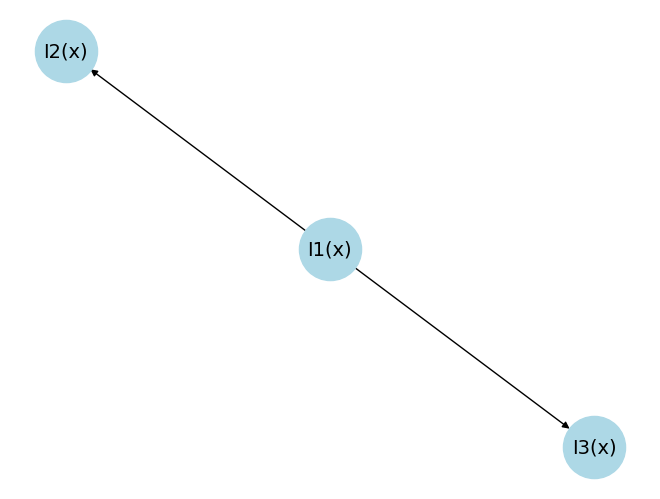

In [12]:
relations2 = {'I1(x)': I1M, 
             'I2(x)': I2M,
             'I3(x)': I3M,
}
phi = ['I1(x)', 'I2(x)', 'I3(x)']

basian_network = build_lifted_network(M2, phi, relations2)
basian_network.table()
basian_network.draw()
plt.show()

Conditional probabilities:
μ(I3(x)) = 3/4
--------------------
μ(I2(x) | I3(x) ∧ I1(x)) = 2/3
μ(I2(x) | I3(x) ∧ ¬I1(x)) = 1/3
μ(I2(x) | ¬I3(x) ∧ I1(x)) = undefined
μ(I2(x) | ¬I3(x) ∧ ¬I1(x)) = 1/3
--------------------
μ(I1(x) | I3(x)) = 2/3
μ(I1(x) | ¬I3(x)) = 0
--------------------


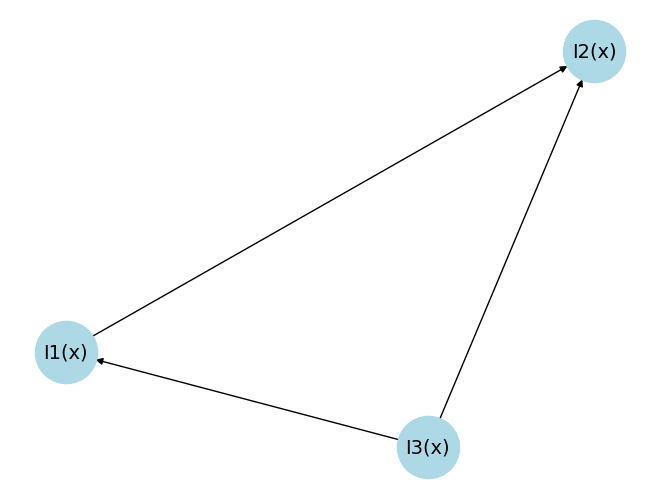

In [13]:
phi = ['I3(x)', 'I1(x)', 'I2(x)', ]

basian_network = build_lifted_network(M2, phi, relations2)
basian_network.table()
basian_network.draw()
plt.show()

Conditional probabilities:
μ(BIG(x)) = 3/8
--------------------
μ(BIG(y)) = 3/8
--------------------
μ(DIRECT(x,y) | BIG(x) ∧ BIG(y)) = 2/3
μ(DIRECT(x,y) | BIG(x) ∧ ¬BIG(y)) = 1/3
μ(DIRECT(x,y) | ¬BIG(x) ∧ BIG(y)) = 1/3
μ(DIRECT(x,y) | ¬BIG(x) ∧ ¬BIG(y)) = 1/10
--------------------


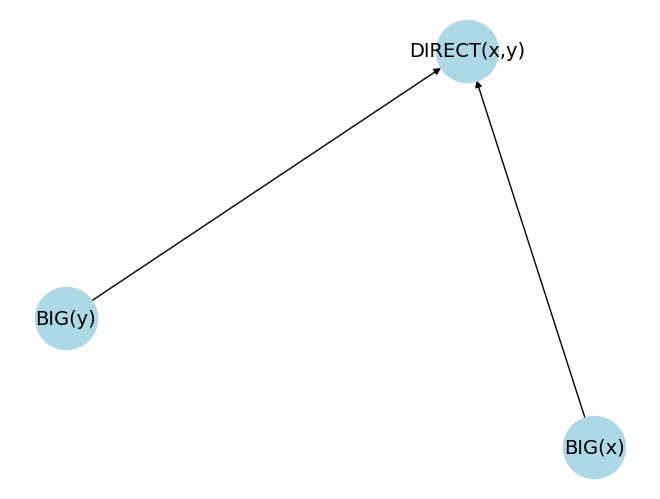

In [14]:
class Big(Base):
    arity = 1
    name = "BIG"
    def __init__(self, *args):
        self.args = args
        assert len(args) == Big.arity

class Direct(Base):
    arity = 2
    name = "DIRECT"
    def __init__(self, *args):
        self.args = args
        assert len(args) == Direct.arity


M3 = {'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'}
BigM = {Big('A'),Big('E'),Big('H')}
DirectM = {Direct('A', 'B'), 
           Direct('B', 'A'), 
           Direct('A', 'H'), 
           Direct('H', 'A'), 
           Direct('B', 'C'), 
           Direct('C', 'B'), 
           Direct('B', 'E'), 
           Direct('E', 'B'), 
           Direct('E', 'D'), 
           Direct('D', 'E'), 
           Direct('E', 'F'), 
           Direct('F', 'E'), 
           Direct('E', 'H'), 
           Direct('H', 'E'), 
           Direct('H', 'G'), 
           Direct('G', 'H'),
           }

relations3 = {'BIG': BigM, 
              'DIRECT': DirectM,
}
phi = [Target('BIG', 'x', 0),Target('BIG', 'y', 1), Target('DIRECT', 'x,y')]

basian_network = build_lifted_network(M3, phi, relations3, arity=2)
basian_network.table()
basian_network.draw()

After evaluating the algorithm on the textbook example i feel confident that it has somewhat reasonable chance of working. Let continue with the assignment 3.

#### Assignment 3
(Learning a Bayesian network) Construct a Bayesian network from M in the way explained in Chapter 5.1 using the following order of the formulas, also viewed as random variables from $M^{2}$ to {0,1}: $P(x), P(y), Q(x), Q(y), R(x,y), S(x,y), T(x,y)$. As explained in Chapter 4, we can identify P(x) with a random variable $P_x: $M^{2}$ → {0,1} such that $P_x(a,b)$ = 1 if M |= P(a) and $P_x(a,b)$ = 0 otherwise. P(y) can be identified with a random variable $P_y: $M^{2}$ → {0,1} such that $P_y(a,b)$ = 1 if M |= P(b) and $P_y(a,b)$ = 0 otherwise. If you need you can use conditions like 'x = y' or 'x ̸= y' when specifying conditions for conditional probabilities (although we don't view such formulas as vertices of the network).

It is also possible, and acceptable, to construct a lifted Bayesian network with vertices $P,Q,R,S,T$ (considered in this order) as defined in Definition 6.2.1 in my notes. The procedure will b e essentially the same and you have to do the same calculations. The resulting lifted Bayesian network will b e similar to the one obtained by the first approach, but not identical since the later has 5 vertices while the first has 7. (In the later approach $P(x)$ and $P(y)$ are identified, and $Q(x)$ and $Q(y)$ are identified.) When determining (conditional) independence you can use the usual mathematical definition of independence, as there is no need for "approximation" in this assignment. Use the counting measure (i.e. uniform probability distribution) μ : M → R when determining (conditional) probabilities.

Conditional probabilities:
μ(P(x)) = 1/2
--------------------
μ(P(y)) = 1/2
--------------------
μ(Q(x)) = 1/2
--------------------
μ(Q(y)) = 1/2
--------------------
μ(S(x,y) | P(x) ∧ R(x,y) ∧ Q(y) ∧ Q(x) ∧ P(y)) = 1/2
μ(S(x,y) | P(x) ∧ R(x,y) ∧ Q(y) ∧ Q(x) ∧ ¬P(y)) = undefined
μ(S(x,y) | P(x) ∧ R(x,y) ∧ Q(y) ∧ ¬Q(x) ∧ P(y)) = undefined
μ(S(x,y) | P(x) ∧ R(x,y) ∧ Q(y) ∧ ¬Q(x) ∧ ¬P(y)) = undefined
μ(S(x,y) | P(x) ∧ R(x,y) ∧ ¬Q(y) ∧ Q(x) ∧ P(y)) = undefined
μ(S(x,y) | P(x) ∧ R(x,y) ∧ ¬Q(y) ∧ Q(x) ∧ ¬P(y)) = undefined
μ(S(x,y) | P(x) ∧ R(x,y) ∧ ¬Q(y) ∧ ¬Q(x) ∧ P(y)) = undefined
μ(S(x,y) | P(x) ∧ R(x,y) ∧ ¬Q(y) ∧ ¬Q(x) ∧ ¬P(y)) = undefined
μ(S(x,y) | P(x) ∧ ¬R(x,y) ∧ Q(y) ∧ Q(x) ∧ P(y)) = undefined
μ(S(x,y) | P(x) ∧ ¬R(x,y) ∧ Q(y) ∧ Q(x) ∧ ¬P(y)) = 0
μ(S(x,y) | P(x) ∧ ¬R(x,y) ∧ Q(y) ∧ ¬Q(x) ∧ P(y)) = 0
μ(S(x,y) | P(x) ∧ ¬R(x,y) ∧ Q(y) ∧ ¬Q(x) ∧ ¬P(y)) = 0
μ(S(x,y) | P(x) ∧ ¬R(x,y) ∧ ¬Q(y) ∧ Q(x) ∧ P(y)) = 0
μ(S(x,y) | P(x) ∧ ¬R(x,y) ∧ ¬Q(y) ∧ Q(x) ∧ ¬P(y)) = 0
μ(S(x,y) | P(x) ∧ ¬R(x,y) ∧ 

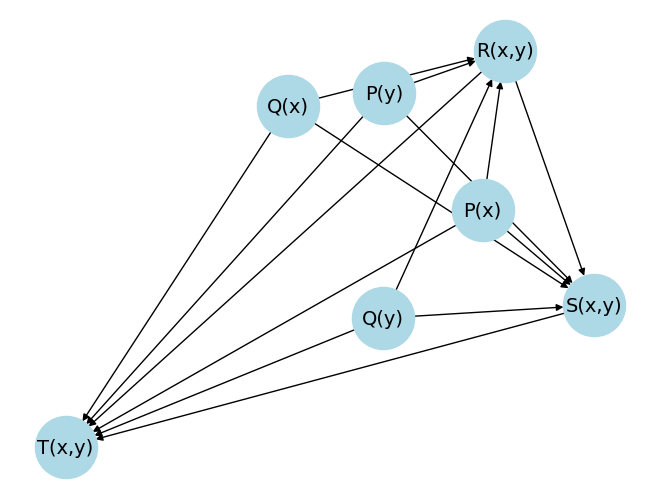

In [15]:
phi = [
    Target('P','x'), 
    Target('P', 'y', 1), 
    Target('Q', 'x'), 
    Target('Q', 'y', 1), 
    Target('R', 'x,y'),
    Target('S', 'x,y'),
    Target('T', 'x,y'),
]
basian_network = build_lifted_network(M, phi, relations, arity=2)
basian_network.table()
basian_network.draw()
plt.show()

```
Conditional probabilities:
μ(P(x)) = 1/2
--------------------
μ(P(y)) = 1/2
--------------------
μ(Q(x)) = 1/2
--------------------
μ(Q(y)) = 1/2
--------------------
μ(R(x,y) | Q(y) ∧ P(x) ∧ P(y) ∧ Q(x)) = 1
μ(R(x,y) | Q(y) ∧ P(x) ∧ P(y) ∧ ¬Q(x)) = 0
μ(R(x,y) | Q(y) ∧ P(x) ∧ ¬P(y) ∧ Q(x)) = 0
μ(R(x,y) | Q(y) ∧ P(x) ∧ ¬P(y) ∧ ¬Q(x)) = 0
μ(R(x,y) | Q(y) ∧ ¬P(x) ∧ P(y) ∧ Q(x)) = 0
μ(R(x,y) | Q(y) ∧ ¬P(x) ∧ P(y) ∧ ¬Q(x)) = 0
μ(R(x,y) | Q(y) ∧ ¬P(x) ∧ ¬P(y) ∧ Q(x)) = 0
μ(R(x,y) | Q(y) ∧ ¬P(x) ∧ ¬P(y) ∧ ¬Q(x)) = 0
μ(R(x,y) | ¬Q(y) ∧ P(x) ∧ P(y) ∧ Q(x)) = 0
μ(R(x,y) | ¬Q(y) ∧ P(x) ∧ P(y) ∧ ¬Q(x)) = 0
μ(R(x,y) | ¬Q(y) ∧ P(x) ∧ ¬P(y) ∧ Q(x)) = 0
μ(R(x,y) | ¬Q(y) ∧ P(x) ∧ ¬P(y) ∧ ¬Q(x)) = 0
μ(R(x,y) | ¬Q(y) ∧ ¬P(x) ∧ P(y) ∧ Q(x)) = 0
μ(R(x,y) | ¬Q(y) ∧ ¬P(x) ∧ P(y) ∧ ¬Q(x)) = 0
μ(R(x,y) | ¬Q(y) ∧ ¬P(x) ∧ ¬P(y) ∧ Q(x)) = 0
μ(R(x,y) | ¬Q(y) ∧ ¬P(x) ∧ ¬P(y) ∧ ¬Q(x)) = 0
--------------------
μ(S(x,y) | Q(y) ∧ P(y) ∧ P(x) ∧ Q(x) ∧ R(x,y)) = 1/2
μ(S(x,y) | Q(y) ∧ P(y) ∧ P(x) ∧ Q(x) ∧ ¬R(x,y)) = undefined
μ(S(x,y) | Q(y) ∧ P(y) ∧ P(x) ∧ ¬Q(x) ∧ R(x,y)) = undefined
μ(S(x,y) | Q(y) ∧ P(y) ∧ P(x) ∧ ¬Q(x) ∧ ¬R(x,y)) = 0
μ(S(x,y) | Q(y) ∧ P(y) ∧ ¬P(x) ∧ Q(x) ∧ R(x,y)) = undefined
μ(S(x,y) | Q(y) ∧ P(y) ∧ ¬P(x) ∧ Q(x) ∧ ¬R(x,y)) = 0
μ(S(x,y) | Q(y) ∧ P(y) ∧ ¬P(x) ∧ ¬Q(x) ∧ R(x,y)) = undefined
μ(S(x,y) | Q(y) ∧ P(y) ∧ ¬P(x) ∧ ¬Q(x) ∧ ¬R(x,y)) = 0
μ(S(x,y) | Q(y) ∧ ¬P(y) ∧ P(x) ∧ Q(x) ∧ R(x,y)) = undefined
μ(S(x,y) | Q(y) ∧ ¬P(y) ∧ P(x) ∧ Q(x) ∧ ¬R(x,y)) = 0
μ(S(x,y) | Q(y) ∧ ¬P(y) ∧ P(x) ∧ ¬Q(x) ∧ R(x,y)) = undefined
μ(S(x,y) | Q(y) ∧ ¬P(y) ∧ P(x) ∧ ¬Q(x) ∧ ¬R(x,y)) = 0
μ(S(x,y) | Q(y) ∧ ¬P(y) ∧ ¬P(x) ∧ Q(x) ∧ R(x,y)) = undefined
μ(S(x,y) | Q(y) ∧ ¬P(y) ∧ ¬P(x) ∧ Q(x) ∧ ¬R(x,y)) = 0
μ(S(x,y) | Q(y) ∧ ¬P(y) ∧ ¬P(x) ∧ ¬Q(x) ∧ R(x,y)) = undefined
μ(S(x,y) | Q(y) ∧ ¬P(y) ∧ ¬P(x) ∧ ¬Q(x) ∧ ¬R(x,y)) = 0
μ(S(x,y) | ¬Q(y) ∧ P(y) ∧ P(x) ∧ Q(x) ∧ R(x,y)) = undefined
μ(S(x,y) | ¬Q(y) ∧ P(y) ∧ P(x) ∧ Q(x) ∧ ¬R(x,y)) = 0
μ(S(x,y) | ¬Q(y) ∧ P(y) ∧ P(x) ∧ ¬Q(x) ∧ R(x,y)) = undefined
μ(S(x,y) | ¬Q(y) ∧ P(y) ∧ P(x) ∧ ¬Q(x) ∧ ¬R(x,y)) = 0
μ(S(x,y) | ¬Q(y) ∧ P(y) ∧ ¬P(x) ∧ Q(x) ∧ R(x,y)) = undefined
μ(S(x,y) | ¬Q(y) ∧ P(y) ∧ ¬P(x) ∧ Q(x) ∧ ¬R(x,y)) = 0
μ(S(x,y) | ¬Q(y) ∧ P(y) ∧ ¬P(x) ∧ ¬Q(x) ∧ R(x,y)) = undefined
μ(S(x,y) | ¬Q(y) ∧ P(y) ∧ ¬P(x) ∧ ¬Q(x) ∧ ¬R(x,y)) = 0
μ(S(x,y) | ¬Q(y) ∧ ¬P(y) ∧ P(x) ∧ Q(x) ∧ R(x,y)) = undefined
μ(S(x,y) | ¬Q(y) ∧ ¬P(y) ∧ P(x) ∧ Q(x) ∧ ¬R(x,y)) = 0
μ(S(x,y) | ¬Q(y) ∧ ¬P(y) ∧ P(x) ∧ ¬Q(x) ∧ R(x,y)) = undefined
μ(S(x,y) | ¬Q(y) ∧ ¬P(y) ∧ P(x) ∧ ¬Q(x) ∧ ¬R(x,y)) = 0
μ(S(x,y) | ¬Q(y) ∧ ¬P(y) ∧ ¬P(x) ∧ Q(x) ∧ R(x,y)) = undefined
μ(S(x,y) | ¬Q(y) ∧ ¬P(y) ∧ ¬P(x) ∧ Q(x) ∧ ¬R(x,y)) = 0
μ(S(x,y) | ¬Q(y) ∧ ¬P(y) ∧ ¬P(x) ∧ ¬Q(x) ∧ R(x,y)) = undefined
μ(S(x,y) | ¬Q(y) ∧ ¬P(y) ∧ ¬P(x) ∧ ¬Q(x) ∧ ¬R(x,y)) = 0
--------------------
μ(T(x,y) | Q(y) ∧ P(y) ∧ S(x,y) ∧ P(x) ∧ Q(x) ∧ R(x,y)) = 1/2
μ(T(x,y) | Q(y) ∧ P(y) ∧ S(x,y) ∧ P(x) ∧ Q(x) ∧ ¬R(x,y)) = undefined
μ(T(x,y) | Q(y) ∧ P(y) ∧ S(x,y) ∧ P(x) ∧ ¬Q(x) ∧ R(x,y)) = undefined
μ(T(x,y) | Q(y) ∧ P(y) ∧ S(x,y) ∧ P(x) ∧ ¬Q(x) ∧ ¬R(x,y)) = undefined
μ(T(x,y) | Q(y) ∧ P(y) ∧ S(x,y) ∧ ¬P(x) ∧ Q(x) ∧ R(x,y)) = undefined
μ(T(x,y) | Q(y) ∧ P(y) ∧ S(x,y) ∧ ¬P(x) ∧ Q(x) ∧ ¬R(x,y)) = undefined
μ(T(x,y) | Q(y) ∧ P(y) ∧ S(x,y) ∧ ¬P(x) ∧ ¬Q(x) ∧ R(x,y)) = undefined
μ(T(x,y) | Q(y) ∧ P(y) ∧ S(x,y) ∧ ¬P(x) ∧ ¬Q(x) ∧ ¬R(x,y)) = undefined
μ(T(x,y) | Q(y) ∧ P(y) ∧ ¬S(x,y) ∧ P(x) ∧ Q(x) ∧ R(x,y)) = 1/2
μ(T(x,y) | Q(y) ∧ P(y) ∧ ¬S(x,y) ∧ P(x) ∧ Q(x) ∧ ¬R(x,y)) = undefined
μ(T(x,y) | Q(y) ∧ P(y) ∧ ¬S(x,y) ∧ P(x) ∧ ¬Q(x) ∧ R(x,y)) = undefined
μ(T(x,y) | Q(y) ∧ P(y) ∧ ¬S(x,y) ∧ P(x) ∧ ¬Q(x) ∧ ¬R(x,y)) = 0
μ(T(x,y) | Q(y) ∧ P(y) ∧ ¬S(x,y) ∧ ¬P(x) ∧ Q(x) ∧ R(x,y)) = undefined
μ(T(x,y) | Q(y) ∧ P(y) ∧ ¬S(x,y) ∧ ¬P(x) ∧ Q(x) ∧ ¬R(x,y)) = 0
μ(T(x,y) | Q(y) ∧ P(y) ∧ ¬S(x,y) ∧ ¬P(x) ∧ ¬Q(x) ∧ R(x,y)) = undefined
μ(T(x,y) | Q(y) ∧ P(y) ∧ ¬S(x,y) ∧ ¬P(x) ∧ ¬Q(x) ∧ ¬R(x,y)) = 0
μ(T(x,y) | Q(y) ∧ ¬P(y) ∧ S(x,y) ∧ P(x) ∧ Q(x) ∧ R(x,y)) = undefined
μ(T(x,y) | Q(y) ∧ ¬P(y) ∧ S(x,y) ∧ P(x) ∧ Q(x) ∧ ¬R(x,y)) = undefined
μ(T(x,y) | Q(y) ∧ ¬P(y) ∧ S(x,y) ∧ P(x) ∧ ¬Q(x) ∧ R(x,y)) = undefined
μ(T(x,y) | Q(y) ∧ ¬P(y) ∧ S(x,y) ∧ P(x) ∧ ¬Q(x) ∧ ¬R(x,y)) = undefined
μ(T(x,y) | Q(y) ∧ ¬P(y) ∧ S(x,y) ∧ ¬P(x) ∧ Q(x) ∧ R(x,y)) = undefined
μ(T(x,y) | Q(y) ∧ ¬P(y) ∧ S(x,y) ∧ ¬P(x) ∧ Q(x) ∧ ¬R(x,y)) = undefined
μ(T(x,y) | Q(y) ∧ ¬P(y) ∧ S(x,y) ∧ ¬P(x) ∧ ¬Q(x) ∧ R(x,y)) = undefined
μ(T(x,y) | Q(y) ∧ ¬P(y) ∧ S(x,y) ∧ ¬P(x) ∧ ¬Q(x) ∧ ¬R(x,y)) = undefined
μ(T(x,y) | Q(y) ∧ ¬P(y) ∧ ¬S(x,y) ∧ P(x) ∧ Q(x) ∧ R(x,y)) = undefined
μ(T(x,y) | Q(y) ∧ ¬P(y) ∧ ¬S(x,y) ∧ P(x) ∧ Q(x) ∧ ¬R(x,y)) = 0
μ(T(x,y) | Q(y) ∧ ¬P(y) ∧ ¬S(x,y) ∧ P(x) ∧ ¬Q(x) ∧ R(x,y)) = undefined
μ(T(x,y) | Q(y) ∧ ¬P(y) ∧ ¬S(x,y) ∧ P(x) ∧ ¬Q(x) ∧ ¬R(x,y)) = 0
μ(T(x,y) | Q(y) ∧ ¬P(y) ∧ ¬S(x,y) ∧ ¬P(x) ∧ Q(x) ∧ R(x,y)) = undefined
μ(T(x,y) | Q(y) ∧ ¬P(y) ∧ ¬S(x,y) ∧ ¬P(x) ∧ Q(x) ∧ ¬R(x,y)) = 0
μ(T(x,y) | Q(y) ∧ ¬P(y) ∧ ¬S(x,y) ∧ ¬P(x) ∧ ¬Q(x) ∧ R(x,y)) = undefined
μ(T(x,y) | Q(y) ∧ ¬P(y) ∧ ¬S(x,y) ∧ ¬P(x) ∧ ¬Q(x) ∧ ¬R(x,y)) = 0
μ(T(x,y) | ¬Q(y) ∧ P(y) ∧ S(x,y) ∧ P(x) ∧ Q(x) ∧ R(x,y)) = undefined
μ(T(x,y) | ¬Q(y) ∧ P(y) ∧ S(x,y) ∧ P(x) ∧ Q(x) ∧ ¬R(x,y)) = undefined
μ(T(x,y) | ¬Q(y) ∧ P(y) ∧ S(x,y) ∧ P(x) ∧ ¬Q(x) ∧ R(x,y)) = undefined
μ(T(x,y) | ¬Q(y) ∧ P(y) ∧ S(x,y) ∧ P(x) ∧ ¬Q(x) ∧ ¬R(x,y)) = undefined
μ(T(x,y) | ¬Q(y) ∧ P(y) ∧ S(x,y) ∧ ¬P(x) ∧ Q(x) ∧ R(x,y)) = undefined
μ(T(x,y) | ¬Q(y) ∧ P(y) ∧ S(x,y) ∧ ¬P(x) ∧ Q(x) ∧ ¬R(x,y)) = undefined
μ(T(x,y) | ¬Q(y) ∧ P(y) ∧ S(x,y) ∧ ¬P(x) ∧ ¬Q(x) ∧ R(x,y)) = undefined
μ(T(x,y) | ¬Q(y) ∧ P(y) ∧ S(x,y) ∧ ¬P(x) ∧ ¬Q(x) ∧ ¬R(x,y)) = undefined
μ(T(x,y) | ¬Q(y) ∧ P(y) ∧ ¬S(x,y) ∧ P(x) ∧ Q(x) ∧ R(x,y)) = undefined
μ(T(x,y) | ¬Q(y) ∧ P(y) ∧ ¬S(x,y) ∧ P(x) ∧ Q(x) ∧ ¬R(x,y)) = 0
μ(T(x,y) | ¬Q(y) ∧ P(y) ∧ ¬S(x,y) ∧ P(x) ∧ ¬Q(x) ∧ R(x,y)) = undefined
μ(T(x,y) | ¬Q(y) ∧ P(y) ∧ ¬S(x,y) ∧ P(x) ∧ ¬Q(x) ∧ ¬R(x,y)) = 0
μ(T(x,y) | ¬Q(y) ∧ P(y) ∧ ¬S(x,y) ∧ ¬P(x) ∧ Q(x) ∧ R(x,y)) = undefined
μ(T(x,y) | ¬Q(y) ∧ P(y) ∧ ¬S(x,y) ∧ ¬P(x) ∧ Q(x) ∧ ¬R(x,y)) = 0
μ(T(x,y) | ¬Q(y) ∧ P(y) ∧ ¬S(x,y) ∧ ¬P(x) ∧ ¬Q(x) ∧ R(x,y)) = undefined
μ(T(x,y) | ¬Q(y) ∧ P(y) ∧ ¬S(x,y) ∧ ¬P(x) ∧ ¬Q(x) ∧ ¬R(x,y)) = 0
μ(T(x,y) | ¬Q(y) ∧ ¬P(y) ∧ S(x,y) ∧ P(x) ∧ Q(x) ∧ R(x,y)) = undefined
μ(T(x,y) | ¬Q(y) ∧ ¬P(y) ∧ S(x,y) ∧ P(x) ∧ Q(x) ∧ ¬R(x,y)) = undefined
μ(T(x,y) | ¬Q(y) ∧ ¬P(y) ∧ S(x,y) ∧ P(x) ∧ ¬Q(x) ∧ R(x,y)) = undefined
μ(T(x,y) | ¬Q(y) ∧ ¬P(y) ∧ S(x,y) ∧ P(x) ∧ ¬Q(x) ∧ ¬R(x,y)) = undefined
μ(T(x,y) | ¬Q(y) ∧ ¬P(y) ∧ S(x,y) ∧ ¬P(x) ∧ Q(x) ∧ R(x,y)) = undefined
μ(T(x,y) | ¬Q(y) ∧ ¬P(y) ∧ S(x,y) ∧ ¬P(x) ∧ Q(x) ∧ ¬R(x,y)) = undefined
μ(T(x,y) | ¬Q(y) ∧ ¬P(y) ∧ S(x,y) ∧ ¬P(x) ∧ ¬Q(x) ∧ R(x,y)) = undefined
μ(T(x,y) | ¬Q(y) ∧ ¬P(y) ∧ S(x,y) ∧ ¬P(x) ∧ ¬Q(x) ∧ ¬R(x,y)) = undefined
μ(T(x,y) | ¬Q(y) ∧ ¬P(y) ∧ ¬S(x,y) ∧ P(x) ∧ Q(x) ∧ R(x,y)) = undefined
μ(T(x,y) | ¬Q(y) ∧ ¬P(y) ∧ ¬S(x,y) ∧ P(x) ∧ Q(x) ∧ ¬R(x,y)) = 0
μ(T(x,y) | ¬Q(y) ∧ ¬P(y) ∧ ¬S(x,y) ∧ P(x) ∧ ¬Q(x) ∧ R(x,y)) = undefined
μ(T(x,y) | ¬Q(y) ∧ ¬P(y) ∧ ¬S(x,y) ∧ P(x) ∧ ¬Q(x) ∧ ¬R(x,y)) = 0
μ(T(x,y) | ¬Q(y) ∧ ¬P(y) ∧ ¬S(x,y) ∧ ¬P(x) ∧ Q(x) ∧ R(x,y)) = undefined
μ(T(x,y) | ¬Q(y) ∧ ¬P(y) ∧ ¬S(x,y) ∧ ¬P(x) ∧ Q(x) ∧ ¬R(x,y)) = 0
μ(T(x,y) | ¬Q(y) ∧ ¬P(y) ∧ ¬S(x,y) ∧ ¬P(x) ∧ ¬Q(x) ∧ R(x,y)) = undefined
μ(T(x,y) | ¬Q(y) ∧ ¬P(y) ∧ ¬S(x,y) ∧ ¬P(x) ∧ ¬Q(x) ∧ ¬R(x,y)) = 0
--------------------
```

This was a massive Basian Network. However it make sense, from the previous assignment we learn concept $P(x0) ∧ P(x1) ∧ Q(x0) ∧ Q(x1) <-> R(x0,x1)$ this is present in the network and it confirms the equivalence of the concept since the conditional probability of $μ(R(x,y) | Q(y) ∧ P(x) ∧ P(y) ∧ Q(x))$ is 1.

Following up on the rest $R(x,y), S(x,y), T(x,y)$ we can se that there is a lot of state overlap in the data and that the dependency are arbitrary and are mostly dependent on the algorithm and the order that we used to construct the network.
